# Deep Reinforcement Learning in Action - Chaper 8 - Intrinsic Curiosity Module - Refactor and Extended

- save model, load model
- save plots of losses and episode lengths
- bug fixes including fixing large memory footprint from saving tensors with gradients to a list
- exposes additional hparams through the param dictionary

In [1]:
import gym
from nes_py.wrappers import JoypadSpace  # A
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT  # B

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque
from tqdm.notebook import trange

from random import shuffle

import matplotlib.pyplot as plt
from skimage.transform import resize  # A
import numpy as np

## Random Agent Mario

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)  # C

done = True
for step in range(2500):  # D
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

## Downscaling

In [3]:
# code intentionally duplicated in training code block
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)  # B
    else:
        return resize(obs, new_size, anti_aliasing=True)

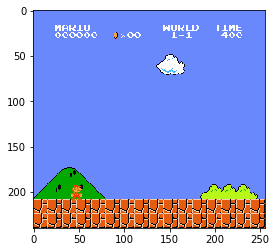

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')

plt.imshow(env.render("rgb_array"))

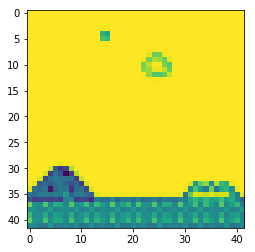

In [5]:
plt.imshow(downscale_obs(env.render("rgb_array")))

In [6]:
env.close()

## Train Agent

In [7]:
# Curiosity-driven Exploration by Self-supervised Prediction
# https://pathak22.github.io/noreward-rl/resources/icml17.pdf
# https://github.com/pathak22/noreward-rl/blob/master/src/constants.py

# TODO: distributional, n-step

import logging
import sys
from einops import rearrange

LOGGER = logging.getLogger(__name__)
LOGGER.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
LOGGER.addHandler(handler)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOGGER.info('Pytorch using device: %s', device)


# Listing 8.9
default_params_book = {
    'batch_size': 150,
    'beta': 0.2,
    'lambda': 0.1,
    'eta': 1.0,
    'gamma': 0.2,
    'max_episode_len': 100,  # this is really the max episode length without exceeding min_progress
    'min_progress': 15,
    'action_repeats': 6,  # something is hard-coded where it will throw an error if < 3
    'frames_per_state': 3,  # book uses 3 and hardcoded it into the models
    'epochs': 5000,
    'eps': 0.15,
    'test_eps': 0.15,
    'switch_to_eps_greedy': 1000,
    'use_extrinsic': False,
    'experience_replay_length': 1000,
    'learning_rate': 0.001,
    'include_LSTM': False,
}

default_params_paper = {
    'batch_size': 1000,
    'beta': 0.2,
    'lambda': 1.0,
    'eta': 0.01,
    'gamma': 0.99,
    'max_episode_len': 100,  # this is really the max episode length without exceeding min_progress
    'min_progress': 15,
    
    # something about the creation of state2 on first pass causes it to throw an error if < frames_per_state
    # now fixed
    'action_repeats': 6,
    
    'frames_per_state': 6,  # book uses 3 and hardcoded it into the models
    'epochs': 6000,
    'eps': 0.15,
    'test_eps': 0.15,
    'switch_to_eps_greedy': 1000,
    'use_extrinsic': True,
    'experience_replay_length': 1000,
    'learning_rate': 0.001,
    'include_LSTM': True,
}

params = {
    'batch_size': 1000,
    'beta': 0.2,
    'lambda': 1.0,
    'eta': 0.01,
    'gamma': 0.99,
    'max_episode_len': 100,  # this is really the max episode length without exceeding min_progress
    'min_progress': 15,
    
    # something about the creation of state2 on first pass causes it to throw an error if < frames_per_state
    # now fixed
    'action_repeats': 6,
    
    'frames_per_state': 6,  # book uses 3 and hardcoded it into the models
    'epochs': 6000,
    'eps': 0.15,
    'test_eps': 0.15,
    'switch_to_eps_greedy': 1000,
    'use_extrinsic': True,
    'experience_replay_length': 1000,
    'learning_rate': 0.001,
    'include_LSTM': True,
}


# Listing 8.2
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)  # B
    else:
        return resize(obs, new_size, anti_aliasing=True)

    
# Listing 8.4
def prepare_state(state):  # A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)


def prepare_multi_state(state1, state2):  # B
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1


def prepare_initial_state(state, N=params['frames_per_state']):  # C
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(dim=0)


# Listing 8.5
def policy(qvalues, eps=None):  # A
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0, high=7, size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        # if epsilon (eps) is not provided, use a softmax policy by sampling from the softmax
        # using the torch.multinomial function
        LOGGER.debug("q values shape: %s", qvalues.shape)
        return torch.multinomial(F.softmax(F.normalize(qvalues), dim=1), num_samples=1)

    
# Listing 8.6
class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N  # A
        self.batch_size = batch_size  # B
        self.memory = []
        self.counter = 0

    def add_memory(self, state1, action, reward, state2):
        self.counter += 1
        if self.counter % 500 == 0:  # C
            self.shuffle_memory()

        if len(self.memory) < self.N:  # D
            self.memory.append((state1, action, reward, state2))
        else:
            rand_index = np.random.randint(0, self.N-1)
            self.memory[rand_index] = (state1, action, reward, state2)

    def shuffle_memory(self):  # E
        shuffle(self.memory)

    def get_batch(self):  # F
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            LOGGER.error("Error: No data in memory.")
            return None
        # G
        ind = np.random.choice(np.arange(len(self.memory)),
                               batch_size, replace=False)
        batch = [self.memory[i] for i in ind]  # batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch], dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch], dim=0)
        LOGGER.debug(state2_batch.shape)
        return state1_batch, action_batch, reward_batch, state2_batch

    
# Listing 8.7
class Phi(nn.Module):  # A
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(
            params['frames_per_state'], 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)

    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))  # size [1, 32, 3, 3] batch, channels, 3 x 3
        y = y.flatten(start_dim=1)  # size N, 288
        return y


class Gnet(nn.Module):  # B
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576, 256)
        self.linear2 = nn.Linear(256, 12)

    def forward(self, state1, state2):
        x = torch.cat((state1, state2), dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y, dim=1)
        return y


class Fnet(nn.Module):  # C
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300, 256)
        self.linear2 = nn.Linear(256, 288)

    def forward(self, state, action):
        action_ = torch.zeros(action.shape[0], 12)  # D
        indices = torch.stack(
            (torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat((state, action_), dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y


# Listing 8.8
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        # in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(in_channels=params['frames_per_state'], out_channels=32, kernel_size=(
            3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.linear1 = nn.Linear(288, 100)
        self.linear2 = nn.Linear(100, 12)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.batchnorm4 = nn.BatchNorm2d(32)
        self.lstm = nn.LSTM(input_size=9, hidden_size=288, batch_first=True)

    def forward(self, x):
        x = F.normalize(x)
        LOGGER.debug("DQN input shape: %s", x.shape)
        y = F.elu(self.conv1(x))
        LOGGER.debug("DQN conv1 output shape: %s", y.shape)
        y = self.batchnorm1(y)
        y = F.elu(self.conv2(y))
        y = self.batchnorm2(y)
        y = F.elu(self.conv3(y))
        y = self.batchnorm3(y)
        y = F.elu(self.conv4(y))
        y = self.batchnorm4(y)
        LOGGER.debug("shape before lstm: %s", y.shape)
        if params['include_LSTM'] == True:
            y = rearrange(y, 'batch channels x y -> batch channels (x y)')
            _, (_, y) = self.lstm(y)
            LOGGER.debug("shape after lstm: %s", y.shape)
            y = rearrange(
                y, 'd batch hidden -> (d batch) hidden', d=1, hidden=288)
        else:
            y = y.flatten(start_dim=2)
            y = y.view(y.shape[0], -1, 32)
            y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y)  # size N, 12
        return y


# Listing 8.9
replay = ExperienceReplay(
    N=params['experience_replay_length'], batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters())  # A
all_model_params += list(forward_model.parameters()) + \
    list(inverse_model.parameters())
opt = optim.Adam(lr=params['learning_rate'], params=all_model_params)


# Listing 8.10
def loss_fn(q_loss, inverse_loss, forward_loss):
    """
    book: minimize[λ × Qloss + (1 – β)Floss + β × Gloss]
    paper: minimize[λ × Qloss + (1 – β)I_loss + (β)F_loss]
    forward model is F
    inverse model is G
    """
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    return loss


def reset_env():
    """
    Reset the environment and return a new initial state
    """
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
    return state1


# Listing 8.11
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1)  # A
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach())  # B
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred,
                                                    state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat)  # C
    inverse_pred_err = inverse_scale * inverse_loss(pred_action,
                                                    action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err


# Listing 8.12
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1)  # A
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)

    forward_pred_err, inverse_pred_err = ICM(
        state1_batch, action_batch, state2_batch)  # B
    i_reward = (1. / params['eta']) * forward_pred_err  # C
    reward = i_reward.detach()  # D
    if use_extrinsic:  # E
        reward += reward_batch
    qvals = Qmodel(state2_batch)  # F
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_batch.shape[0]),
                           action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred),
                         F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss


# Listing 8.13
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)  # C

env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))

losses = []
episode_length = 0

# this prevents storing more action repeats than frames_per_state
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.

# keep track of the last x position in order to reset it if there's no forward progress
last_x_pos = env.env.env._x_position

ep_lengths = []
for i in trange(params['epochs']):
    opt.zero_grad()
    episode_length += 1
    # run DQN forward to get action-value predictions
    q_val_pred = Qmodel(state1)
    # after x epochs, switch to the epsilon-greedy policy
    if i > params['switch_to_eps_greedy']:
        action = int(policy(q_val_pred, params['eps']))
    else:
        action = int(policy(q_val_pred))
    # repeat action selected by policy x times to speed up learning
    for j in range(params['action_repeats']):
        state2, e_reward_, done, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    while len(state_deque) < params['frames_per_state']:
        print("adding to queue")
        # this should prevent the error caused when action_repeats < frames_per_state
        state_deque.append(prepare_state(state2))
    # convert deque object into a tensor
    state2 = torch.stack(list(state_deque), dim=1)
    LOGGER.debug("state2.shape: %s", state2.shape)
    # add single experience to replay buffer
    replay.add_memory(state1, action, e_reward, state2)
    e_reward = 0
    # if Mario is not making enough forward progress, restart game
    if episode_length > params['max_episode_len']:
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = env.env.env._x_position
        episode_length = 0
    else:
        # this causes an error when action_repeats < frames_per_state
        LOGGER.debug("state2.shape: %s", state2.shape)
        state1 = state2
    if params['experience_replay_length'] < params['batch_size']:
        raise ValueError(
            "params['experience_replay_length'] < params['batch_size'] will cause model not to train")
    if len(replay.memory) < params['batch_size']:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(
        use_extrinsic=params['use_extrinsic'])  # get errors for one mini-batch of data from replay buffer

    # compute overall loss
    loss = loss_fn(q_loss=q_loss,
                   inverse_loss=inverse_pred_err,
                   forward_loss=forward_pred_err)

    # it's important to not save the losses to a list directly because then you're saving the gradients as well
    loss_list = (q_loss.mean().detach().numpy(), forward_pred_err.flatten().mean().detach().numpy(),
                 inverse_pred_err.flatten().mean().detach().numpy())
    LOGGER.debug("loss list: %s", loss_list)
    losses.append(loss_list)
    loss.backward()
    opt.step()
env.close()

2021-11-01 09:51:21,027 - __main__ - INFO - Pytorch using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

## Name model for saving files

In [8]:
model_version_name = 'mario_curiosity_model_with_extrinsic_reward_long_frames_per_state_v5'

## Plot losses and episode length

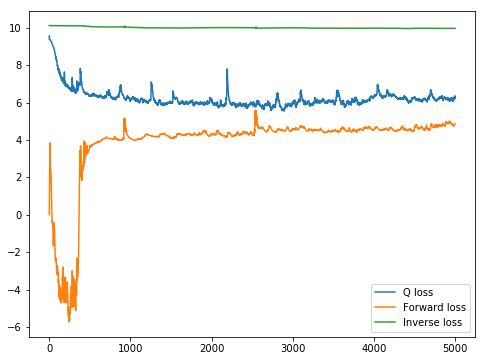

In [9]:
## now handling this inside the training function
# losses_ = np.array([tuple([loss.detach().numpy()
#                    for loss in loss_tensor_tuple]) for loss_tensor_tuple in losses])

losses_ = np.array(losses)
plt.figure(figsize=(8, 6))
plt.plot(np.log(losses_[:, 0]), label='Q loss')
plt.plot(np.log(losses_[:, 1]), label='Forward loss')
plt.plot(np.log(losses_[:, 2]), label='Inverse loss')
plt.legend()
plt.savefig(f'{model_version_name}_losses.png')
plt.show()

# https://stackoverflow.com/questions/55466298/pytorch-cant-call-numpy-on-variable-that-requires-grad-use-var-detach-num
# https://stackoverflow.com/questions/16940293/why-is-there-no-tuple-comprehension-in-python

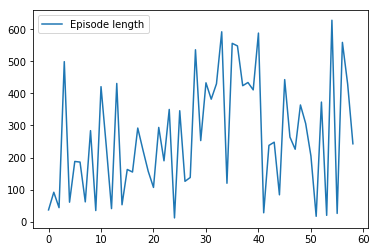

In [10]:
plt.figure()
plt.plot(np.array(ep_lengths), label='Episode length')
# plt.xlabel('Training time')
# plt.ylabel('Episode length')
plt.legend()
plt.savefig(f'{model_version_name}_episode_lengths.png')
plt.show()

## save model

In [11]:
import json
torch.save(Qmodel, f'{model_version_name}.pt')
with open(f'{model_version_name}_config.json', 'w') as outfile:
    json.dump(params, outfile)

## load model

In [12]:
Qmodel = torch.load(f'{model_version_name}.pt')
Qmodel.eval()  # needed for dropout and/or batchnorm layers to function correctly for inference

Qnetwork(
  (conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (linear1): Linear(in_features=288, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=12, bias=True)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(9, 288, batch_first=True)
)

## Test Trained Agent

In [15]:
save_video = True
render_also = True

if save_video:
    from gym.wrappers.monitoring.video_recorder import VideoRecorder

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)  # C

if save_video:
    video_recorder = None
    video_recorder = VideoRecorder(
        env, f'{model_version_name}_gameplay.mp4', enabled=True)

done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(10000):
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render('rgb_array'))
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred, params['test_eps']))
    state2, reward, done, info = env.step(action)
    state2 = prepare_multi_state(state1, state2)
    state1 = state2

    if save_video:
        video_recorder.capture_frame()
        if render_also:
            env.render()
    else:
        env.render()

if save_video:
    video_recorder.close()
    video_recorder.enabled = False

env.close()

In [14]:
# # if you're done, run env.close()
# env.close()